# CatBoost vs XGBoost - A CatBoost Introduction

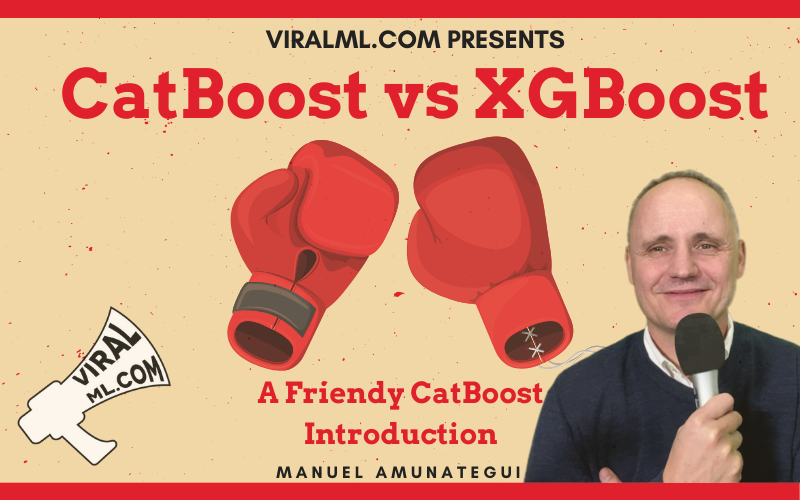

In [1]:
from IPython.display import Image
Image(filename='CatBoost vs Xgboost.png' )


Let's pit CatBoost against XGBoost in a friendly classificiation battle! Cat Fight Time

I got some of my best scores on Kaggle using it! At one point, I was ranked 185th and I thank XGBoost ( https://www.kaggle.com/amunategui ), lot's of others thanked XGBoost too. We still thank it today - it's integrated all over the place - scikit-learn, cloud providers, I use it everyday for customers in GCP as it is now compatible with Cloud ML, so you can model terrabytes of data using it.

GCP Built-in XGBoost algorithm https://cloud.google.com/ml-engine/docs/algorithms/xgboost-start

Scikit-Learn API Scikit-Learn Wrapper interface for XGBoost https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn


In [1]:
# installing catboost and xgboost

# !pip3 install catboost --user
# !pip3 install xgboost --user

In [13]:
# Let's compare XGBoost to CatBoost

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

from pandas_profiling import ProfileReport

import catboost
print('catboost version:', catboost.__version__)
import xgboost
print('xgboost version:', xgboost.__version__)


catboost version: 0.20.2
xgboost version: 0.90


### Let's get an independent Titanic data set from the Vanderbilt University

In [3]:
titanic_df = pd.read_csv('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv')
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [15]:
profile = ProfileReport(titanic_df)

In [16]:
profile

In [4]:
# simple feature engineering

# strip first letter from cabin number if there
titanic_df['cabin'] = titanic_df['cabin'].replace(np.NaN, 'U') 
titanic_df['cabin'] = [ln[0] for ln in titanic_df['cabin'].values]
titanic_df['cabin'] = titanic_df['cabin'].replace('U', 'Unknown') 
titanic_df['cabin'].head()

0    B
1    C
2    C
3    C
4    C
Name: cabin, dtype: object

In [5]:
# create isfemale field and use numerical values
titanic_df['isfemale'] = np.where(titanic_df['sex'] == 'female', 1, 0)

# drop features not needed for model 
titanic_df = titanic_df[[f for f in list(titanic_df) if f not in ['sex', 'name', 'boat','body', 'ticket', 'home.dest']]]

# make pclass actual categorical column
titanic_df['pclass'] = np.where(titanic_df['pclass'] == 1, 'First', 
                                np.where(titanic_df['pclass'] == 2, 'Second', 'Third'))


titanic_df['embarked'] = titanic_df['embarked'].replace(np.NaN, 'Unknown') 


titanic_df.head()

,pclass,survived,age,sibsp,parch,fare,cabin,embarked,isfemale
0,First,1,29.00,0,0,211.3375,B,S,1
1,First,1,0.92,1,2,151.5500,C,S,0
2,First,0,2.00,1,2,151.5500,C,S,1
3,First,0,30.00,1,2,151.5500,C,S,0
4,First,0,25.00,1,2,151.5500,C,S,1


In [6]:
# how many nulls do we have?
titanic_df.isna().sum() 

pclass        0
survived      0
age         263
sibsp         0
parch         0
fare          1
cabin         0
embarked      0
isfemale      0
dtype: int64

In [7]:
# impute age to mean
titanic_df['age'] = titanic_df['age'].fillna(titanic_df['age'].mean())
titanic_df['age']

0       29.000000
1        0.920000
2        2.000000
3       30.000000
4       25.000000
          ...    
1304    14.500000
1305    29.881138
1306    26.500000
1307    27.000000
1308    29.000000
Name: age, Length: 1309, dtype: float64

In [8]:
# SEED - play around with this variable as it will change winners
SEED = 1234 # try 0

## CatBoost's Turn!

In [9]:
titanic_df.head()

,pclass,survived,age,sibsp,parch,fare,cabin,embarked,isfemale
0,First,1,29.00,0,0,211.3375,B,S,1
1,First,1,0.92,1,2,151.5500,C,S,0
2,First,0,2.00,1,2,151.5500,C,S,1
3,First,0,30.00,1,2,151.5500,C,S,0
4,First,0,25.00,1,2,151.5500,C,S,1


In [11]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
pclass      1309 non-null object
survived    1309 non-null int64
age         1309 non-null float64
sibsp       1309 non-null int64
parch       1309 non-null int64
fare        1308 non-null float64
cabin       1309 non-null object
embarked    1309 non-null object
isfemale    1309 non-null int32
dtypes: float64(2), int32(1), int64(3), object(3)
memory usage: 87.1+ KB


In [10]:
# map categorical features
titanic_catboost_ready_df = titanic_df.dropna() 

features = [feat for feat in list(titanic_catboost_ready_df) if feat != 'survived']
print(features)
titanic_categories = np.where(titanic_catboost_ready_df[features].dtypes != np.float)[0]
titanic_categories

['pclass', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'embarked', 'isfemale']


array([0, 2, 3, 5, 6, 7], dtype=int64)

In [12]:
from catboost import CatBoostClassifier 

X_train, X_test, y_train, y_test = train_test_split(titanic_df[features], 
                                                    titanic_df[['survived']], 
                                                    test_size=0.3, 
                                                     random_state=SEED)
 

params = {'iterations':5000,
        'learning_rate':0.01,
        'cat_features':titanic_categories,
        'depth':3,
        'eval_metric':'AUC',
        'verbose':200,
        'od_type':"Iter", # overfit detector
        'od_wait':500, # most recent best iteration to wait before stopping
        'random_seed': SEED
          }

cat_model = CatBoostClassifier(**params)
cat_model.fit(X_train, y_train,   
          eval_set=(X_test, y_test), 
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
          plot=True  
         );
 



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8269924	best: 0.8269924 (0)	total: 172ms	remaining: 14m 20s
200:	test: 0.8437691	best: 0.8450862 (179)	total: 1.07s	remaining: 25.6s
400:	test: 0.8479008	best: 0.8484554 (369)	total: 1.9s	remaining: 21.8s
600:	test: 0.8509234	best: 0.8509511 (592)	total: 2.69s	remaining: 19.7s
800:	test: 0.8510205	best: 0.8514364 (786)	total: 3.5s	remaining: 18.3s
1000:	test: 0.8497865	best: 0.8520742 (851)	total: 4.3s	remaining: 17.2s
1200:	test: 0.8528645	best: 0.8530864 (1191)	total: 5.3s	remaining: 16.8s
1400:	test: 0.8538628	best: 0.8540014 (1359)	total: 6.27s	remaining: 16.1s
1600:	test: 0.8547363	best: 0.8552077 (1557)	total: 7.28s	remaining: 15.5s
1800:	test: 0.8551106	best: 0.8553602 (1787)	total: 8.3s	remaining: 14.7s
2000:	test: 0.8557762	best: 0.8557762 (2000)	total: 9.39s	remaining: 14.1s
2200:	test: 0.8568992	best: 0.8568992 (2197)	total: 10.6s	remaining: 13.4s
2400:	test: 0.8584244	best: 0.8586462 (2357)	total: 11.7s	remaining: 12.7s
2600:	test: 0.8599773	best: 0.8600882 (2591

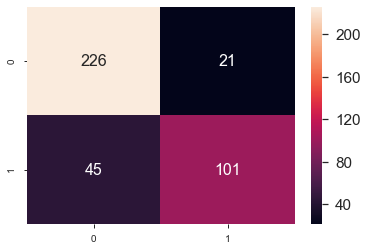

In [17]:
# Confusion matrix
dval_predictions = cat_model.predict(X_test)
dval_predictions

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, [1 if p > 0.5 else 0 for p in dval_predictions])

plt.figure(figsize = (6,4))
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
sns.set(font_scale=1.4)
sns.heatmap(cm, fmt='.3g', annot=True, annot_kws={"size": 16}) 
plt.show()

In [18]:
cat_model.get_feature_importance()

array([13.47392213, 14.06654777,  4.57348393,  4.04448054, 17.05781177,
        7.42358554,  7.38780932, 31.972359  ])

In [19]:
feat_import = [t for t in zip(features, cat_model.get_feature_importance())]
feat_import_df = pd.DataFrame(feat_import, columns=['Feature', 'VarImp'])
feat_import_df = feat_import_df.sort_values('VarImp', ascending=False)
feat_import_df[feat_import_df['VarImp'] > 0]

,Feature,VarImp
7,isfemale,31.972359
4,fare,17.057812
1,age,14.066548
0,pclass,13.473922
5,cabin,7.423586
6,embarked,7.387809
2,sibsp,4.573484
3,parch,4.044481


## XGBoost's Turn

### Dummy/one-hot only for XGBoost

In [20]:
titanic_df.isnull().any()

pclass      False
survived    False
age         False
sibsp       False
parch       False
fare         True
cabin       False
embarked    False
isfemale    False
dtype: bool

In [21]:
def prepare_data_for_model(raw_dataframe, target_columns, drop_first = True, make_na_col = False):
    # dummy all categorical fields 
    dataframe_dummy = pd.get_dummies(raw_dataframe, columns=target_columns, 
                                     drop_first=drop_first, 
                                     dummy_na=make_na_col)
    return (dataframe_dummy)

# create dummy features 
titanic_xgboost_ready_df = prepare_data_for_model(titanic_df, target_columns=['pclass', 'cabin', 'embarked'])
titanic_xgboost_ready_df = titanic_xgboost_ready_df.dropna() 

list(titanic_xgboost_ready_df)

['survived',
 'age',
 'sibsp',
 'parch',
 'fare',
 'isfemale',
 'pclass_Second',
 'pclass_Third',
 'cabin_B',
 'cabin_C',
 'cabin_D',
 'cabin_E',
 'cabin_F',
 'cabin_G',
 'cabin_T',
 'cabin_Unknown',
 'embarked_Q',
 'embarked_S',
 'embarked_Unknown']

In [22]:
# split data into train and test portions and model
features = [feat for feat in list(titanic_xgboost_ready_df) if feat != 'survived']
X_train, X_test, y_train, y_test = train_test_split(titanic_xgboost_ready_df[features], 
                                                 titanic_xgboost_ready_df[['survived']], 
                                                test_size=0.3, 
                                                 random_state=SEED)
 

import xgboost  as xgb
xgb_params = {
    'max_depth':3, 
    'eta':0.01, 
    'silent':0, 
    'eval_metric':'auc',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective':'binary:logistic',
    'seed' : SEED
}

dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)
dtest = xgb.DMatrix(X_test, y_test, feature_names=X_test.columns.values)

evals = [(dtrain,'train'),(dtest,'eval')]
xgb_model = xgb.train ( params = xgb_params,
              dtrain = dtrain,
              num_boost_round = 5000,
              verbose_eval=200, 
              early_stopping_rounds = 500,
              evals=evals,
              maximize = True)

[0]	train-auc:0.82826	eval-auc:0.835067
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 500 rounds.
[200]	train-auc:0.882618	eval-auc:0.861012
[400]	train-auc:0.895644	eval-auc:0.862583
[600]	train-auc:0.906906	eval-auc:0.867158
[800]	train-auc:0.916957	eval-auc:0.868701
[1000]	train-auc:0.924613	eval-auc:0.871691
[1200]	train-auc:0.930926	eval-auc:0.872358
[1400]	train-auc:0.935523	eval-auc:0.873109
[1600]	train-auc:0.939874	eval-auc:0.873721
[1800]	train-auc:0.943707	eval-auc:0.87272
Stopping. Best iteration:
[1480]	train-auc:0.937601	eval-auc:0.874499



In [23]:
# get dataframe version of important feature for model 
xgb_fea_imp=pd.DataFrame(list(xgb_model.get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
xgb_fea_imp.head(10)

,feature,importance
3,fare,4620
2,age,3616
0,isfemale,710
4,sibsp,658
8,embarked_S,472
6,parch,367
5,pclass_Third,365
1,cabin_Unknown,325
9,pclass_Second,193
10,embarked_Q,191


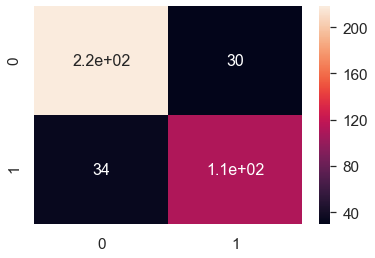

In [24]:
# Confusion matrix
dval_predictions = xgb_model.predict(dtest)
dval_predictions

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, [1 if p > 0.5 else 0 for p in dval_predictions])

plt.figure(figsize = (6,4))
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}) 
plt.show()

# Final Winners

In [25]:
xgb_model.best_score

0.874499

In [26]:
cat_model.best_score_

{'learn': {'Logloss': 0.3051226040287972},
 'validation': {'Logloss': 0.420140033016464, 'AUC': 0.8639426543175642}}

# Let's dive deep into CatBoost!

Initial release date: July 18, 2017 by Yandex researchers and is open sourced

https://catboost.ai/

pip install catboost

Quick start
https://catboost.ai/docs/concepts/python-quickstart.html
    

# CatBoostClassifier

In [27]:
from catboost.datasets import titanic
titanic_train, titanic_test = titanic()

print(titanic_train.head(3))

titanic_train.shape

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  


(891, 12)

In [28]:
titanic_test.shape

(418, 11)

In [30]:
# pip install pandas-profiling
import pandas_profiling as pp
pp.ProfileReport(titanic_train)

In [31]:
# clean up NaNs
titanic_train.isnull().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [32]:
# impute age to mean
titanic_train['Age'] = titanic_train['Age'].fillna(titanic_train['Age'].mean())
titanic_train['Embarked'] = titanic_train['Embarked'].replace(np.nan, 'Unknown', regex=True)

In [33]:
from catboost import CatBoostClassifier

# data split
outome_name = 'Survived'
features_for_model =['Pclass', 'Sex', 'Age', 'Embarked']


# data split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(titanic_train[features_for_model], 
                                                 titanic_train[outome_name], 
                                                 test_size=0.3, 
                                                 random_state=1)

# tell catboost which are categorical columns
titanic_categories = np.where(X_train[features_for_model].dtypes != np.float)[0]
print('titanic_categories:', titanic_categories)
 

titanic_categories: [0 1 3]


In [34]:
params = {'iterations':1000,
        'learning_rate':0.01,
        'cat_features':titanic_categories,
        'depth':3,
        'eval_metric':'AUC',
        'verbose':200,
        'od_type':"Iter", # overfit detector
        'od_wait':500,  
         }

 

model_classifier = CatBoostClassifier(**params)
                       
model_classifier.fit(X_train, y_train, 
                     eval_set=(X_test, y_test),  
                     use_best_model=True, 
                     plot= True  
                    );
 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7554419	best: 0.7554419 (0)	total: 20.7ms	remaining: 20.7s
200:	test: 0.8107133	best: 0.8157431 (28)	total: 493ms	remaining: 1.96s
400:	test: 0.8169082	best: 0.8169082 (343)	total: 1.02s	remaining: 1.53s
600:	test: 0.8160557	best: 0.8183007 (403)	total: 1.66s	remaining: 1.1s
800:	test: 0.8196363	best: 0.8213413 (738)	total: 2.2s	remaining: 547ms
999:	test: 0.8202330	best: 0.8213413 (738)	total: 2.65s	remaining: 0us

bestTest = 0.8213412901
bestIteration = 738

Shrink model to first 739 iterations.


In [35]:
# feature importance 
feat_import = [t for t in zip(features_for_model, model_classifier.get_feature_importance())]
feat_import_df = pd.DataFrame(feat_import, columns=['Feature', 'VarImp'])
feat_import_df = feat_import_df.sort_values('VarImp', ascending=False)
feat_import_df.head(20)

,Feature,VarImp
1,Sex,56.915324
0,Pclass,26.666115
2,Age,10.183606
3,Embarked,6.234955


# CatBoostRegressor

## Boston house prices dataset

The Boston Housing Dataset consists of price of houses in various places in Boston. Alongside with price, the dataset also provide information such as Crime (CRIM), areas of non-retail business in the town (INDUS), the age of people who own the house (AGE).


In [36]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()
boston_dataset.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [37]:
for ln in boston_dataset.DESCR.split('\n'):
    print(ln)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [38]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10


In [39]:
# Our target variable - Median value of owner-occupied homes in $1000s
boston['MEDV'] = boston_dataset.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
pp.ProfileReport(boston)

In [34]:
# clean up NaNs
boston.isnull().sum(axis=0)

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [35]:
from catboost import CatBoostRegressor

# data split
outome_name = 'MEDV'
features_for_model = [f for f in list(boston) if f not in [outome_name, 'TAX']]

# get categories and cast to string
boston_categories = np.where([boston[f].apply(float.is_integer).all() for f in features_for_model])[0]
print('boston_categories:', boston_categories)

# convert to values to string
for feature in [list(boston[features_for_model])[f] for f in list(boston_categories)]:
    print(feature)
    boston[feature] = boston[feature].to_string()


# data split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(boston[features_for_model], 
                                                 boston[outome_name], 
                                                 test_size=0.3, 
                                                 random_state=1)




params = {'iterations':5000,
        'learning_rate':0.001,
        'depth':3,
        'loss_function':'RMSE',
        'eval_metric':'RMSE',
        'random_seed':55,
        'cat_features':boston_categories,
        'metric_period':200,  
        'od_type':"Iter",  
        'od_wait':20,  
        'verbose':True,
        'use_best_model':True}


model_regressor = CatBoostRegressor(**params)

model_regressor.fit(X_train, y_train, 
          eval_set=(X_test, y_test),  
          use_best_model=True,  
          plot= True   
         );


boston_categories: [3 8]
CHAS
RAD


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 9.0062199	test: 9.5913153	best: 9.5913153 (0)	total: 3.52ms	remaining: 17.6s
200:	learn: 8.1097535	test: 8.6739924	best: 8.6739924 (200)	total: 398ms	remaining: 9.51s
400:	learn: 7.3671975	test: 7.9052743	best: 7.9052743 (400)	total: 733ms	remaining: 8.41s
600:	learn: 6.7332418	test: 7.2399556	best: 7.2399556 (600)	total: 1.12s	remaining: 8.17s
800:	learn: 6.1944857	test: 6.6637468	best: 6.6637468 (800)	total: 1.51s	remaining: 7.92s
1000:	learn: 5.7395102	test: 6.1776956	best: 6.1776956 (1000)	total: 1.81s	remaining: 7.24s
1200:	learn: 5.3595767	test: 5.7679251	best: 5.7679251 (1200)	total: 2.07s	remaining: 6.55s
1400:	learn: 5.0351836	test: 5.4117721	best: 5.4117721 (1400)	total: 2.33s	remaining: 5.99s
1600:	learn: 4.7588279	test: 5.1042392	best: 5.1042392 (1600)	total: 2.7s	remaining: 5.74s
1800:	learn: 4.5228107	test: 4.8422938	best: 4.8422938 (1800)	total: 3.11s	remaining: 5.53s
2000:	learn: 4.3186420	test: 4.6256193	best: 4.6256193 (2000)	total: 3.43s	remaining: 5.14s
22

In [36]:
# feature importance 
feat_import = [t for t in zip(features_for_model, model_regressor.get_feature_importance())]
feat_import_df = pd.DataFrame(feat_import, columns=['Feature', 'VarImp'])
feat_import_df = feat_import_df.sort_values('VarImp', ascending=False)
feat_import_df.head(20)

,Feature,VarImp
11,LSTAT,44.676129
5,RM,27.315121
7,DIS,7.292907
4,NOX,5.959828
9,PTRATIO,4.406179
0,CRIM,4.102309
6,AGE,2.862897
2,INDUS,1.677943
10,B,1.504728
1,ZN,0.201959
